In [4]:
from __future__ import annotations

from math import pi
from oscar import Landscape, plot_2d_landscape

n = 4
resolution = [64, 64]
bounds = [(-pi, pi), (-pi, pi)]
sampling_fraction = 1 / 16

Define the problem with PySCF and initialize the qubit mapper and ansatz with Qiskit.

In [5]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto-3g")
problem = driver.run()

mapper = JordanWignerMapper()

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

To get 2D landscapes suitable for visualization, we fix one of the parameters to a desired value (0 in the below example) to view a "slice" of the high-dimensional landscape.

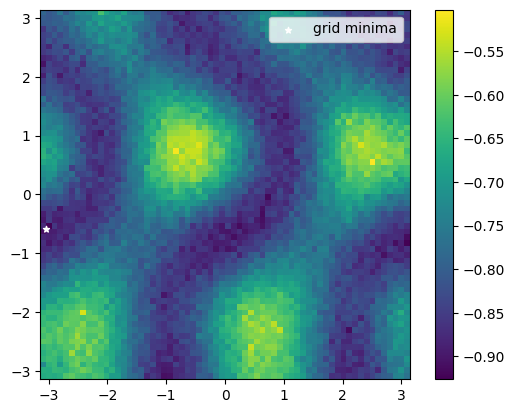

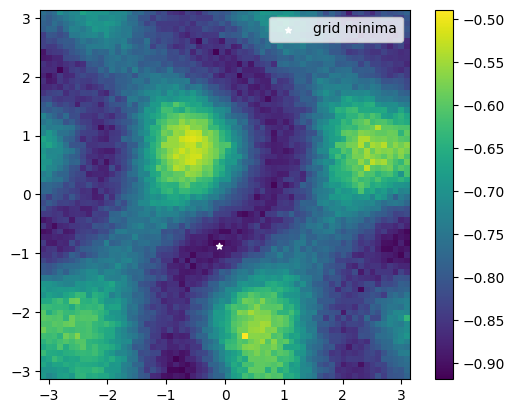

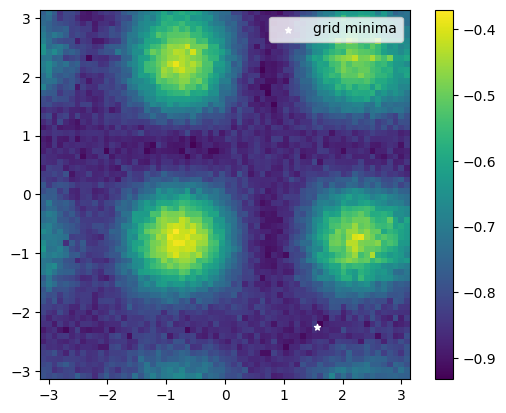

In [6]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_aer.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from oscar import QiskitExecutor


landscapes = []
for i in range(len(ansatz.parameters)):
    vqe = VQE(
        Estimator(run_options={"shots": None}),
        ansatz.assign_parameters({ansatz.parameters[i]: 0}), # fix one parameter
        SLSQP(),
    )
    solver = GroundStateEigensolver(mapper, vqe)
    operator, _ = solver.get_qubit_operators(problem)
    executor = QiskitExecutor(vqe, operator)
    landscape = Landscape(resolution, bounds)
    landscape.sample_and_run(executor, sampling_fraction)
    landscape.reconstruct()
    plot_2d_landscape(landscape)
    landscapes.append(landscape)